# 1. Import Dependensi

In [1]:
import os
import tensorflow as tf 
import tensorflow_io as tfio
import matplotlib.pyplot as plt

2024-07-01 12:10:59.809932: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-01 12:10:59.840978: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 12:10:59.841013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 12:10:59.841773: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-01 12:10:59.850620: I tensorflow/core/platform/cpu_feature_guar

In [2]:
tfio.__version__

'0.35.0'

# 2. Data Loading

### 2.1 Path menuju file

In [3]:
LEAK_SAMPLE = os.path.join('audio', 'Leak', 'Mic 1-1719421513.wav')
NORMAL_SAMPLE = os.path.join('audio', 'No Leak', 'Mic 1-1719758249.wav')

NOISE_PROFILE = os.path.join('audio', 'profile.wav')

### 2.2 Data Loading Function

In [4]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 4000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=4000)
    return wav

### 2.3 Plot Wavefile

In [5]:
leak_wave = load_wav_16k_mono(LEAK_SAMPLE)
normal_wave = load_wav_16k_mono(NORMAL_SAMPLE)

2024-07-01 12:11:01.721549: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-01 12:11:01.753650: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-01 12:11:01.753691: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-01 12:11:01.757528: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-01 12:11:01.757619: I external/local_xla/xla/stream_executor

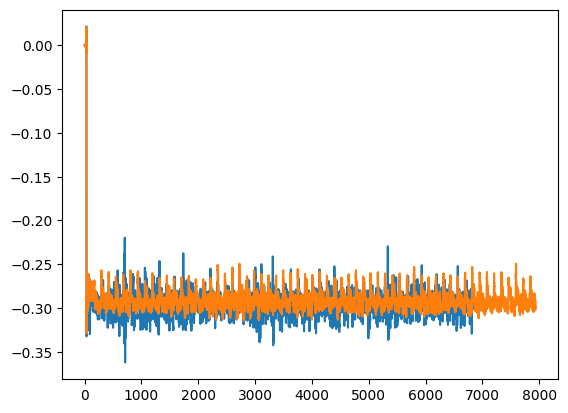

In [6]:
plt.plot(leak_wave)
plt.plot(normal_wave)
plt.show()

# 3. Create Tensorflow Dataset

### 3.1 Define Paths to LEAK and NORMAL Data

In [7]:
LEAK = os.path.join('audio', 'Leak')
NORMAL = os.path.join('audio', 'No Leak')

In [8]:
LEAK

'audio/Leak'

### 3.2 Create Tensorflow Datasets

In [9]:
leak = tf.data.Dataset.list_files(LEAK + '/*.wav')
normal = tf.data.Dataset.list_files(NORMAL + '/*.wav')

2024-07-01 12:11:02.907536: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


### 3.3 Add labels and Combine LEAK and NORMAL Samples

In [10]:
leaks = tf.data.Dataset.zip((leak, tf.data.Dataset.from_tensor_slices(tf.ones(len(leak)))))
normals = tf.data.Dataset.zip((normal, tf.data.Dataset.from_tensor_slices(tf.zeros(len(normal)))))
data = leaks.concatenate(normals)

# 4. Average Length

### 4.1 Calculate Wave Cycle Length

In [11]:
lengths = []
for file in os.listdir(os.path.join('audio', 'Leak')):
    tensor_wave = load_wav_16k_mono(os.path.join('audio', 'Leak', file))
    lengths.append(len(tensor_wave))

### 4.2 Calculate Mean, Min and Max

In [12]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=7926>

In [13]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=6496>

In [14]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=7968>

# 5. Build Preprocessing Function to Convert to Spectrogram

### 5.1 Build Preprocessing Function

In [15]:
# Define a function for spectral subtraction
def spectral_subtraction(wav, noise_profile, frame_length=1024, frame_step=512):
    # Compute the STFT of both the signal and the noise
    wav_stft = tf.signal.stft(wav, frame_length=frame_length, frame_step=frame_step)
    noise_stft = tf.signal.stft(noise_profile, frame_length=frame_length, frame_step=frame_step)

    # Estimate the mean noise spectrogram
    mean_noise_amp = tf.reduce_mean(tf.abs(noise_stft), axis=0)

    # Subtract the mean noise amplitude from the signal's magnitude
    signal_mag = tf.abs(wav_stft) - mean_noise_amp
    signal_mag = tf.maximum(signal_mag, 0)  # Ensure the spectrum is non-negative

    # Reconstruct the signal using the original phase
    signal_phase = tf.math.angle(wav_stft)
    
    # Reconstruct the complex-valued STFT using magnitude and phase
    signal_real = signal_mag * tf.cos(signal_phase)
    signal_imag = signal_mag * tf.sin(signal_phase)
    denoised_stft = tf.complex(signal_real, signal_imag)
    
    return denoised_stft

In [16]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:7000]

    # Load noise profile
    noise_profile = load_wav_16k_mono(NOISE_PROFILE)
    noise_profile = noise_profile[:7000]
    
    zp_profile = tf.zeros([7000] - tf.shape(noise_profile), dtype=tf.float32)
    noise_profile = tf.concat([zp_profile, noise_profile],0)

    zero_padding = tf.zeros([7000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)

    # Perform spectral subtraction
    denoised_stft = spectral_subtraction(wav, noise_profile, 64, 30)
    
    spectrogram = tf.abs(denoised_stft)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

### 5.2 Test Out the Function and Viz the Spectrogram

In [17]:
# filepath, label = normals.shuffle(buffer_size=10000).as_numpy_iterator().next()
filepath, label = leaks.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [18]:
spectrogram, label = preprocess(filepath, label)

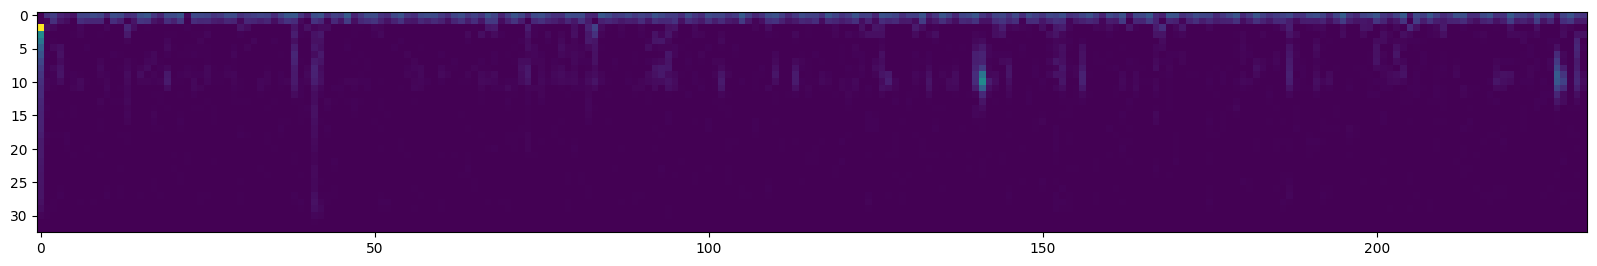

In [19]:
plt.figure(figsize=(20,5))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

### 6.1 Create a Tensorflow Data Pipeline

In [20]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(8)
data = data.prefetch(2)

In [21]:
len(data)

563

In [22]:
total_size = len(data)  # Example total size of dataset
train_size = int(total_size * 0.8)  # 60% of data for training
test_size = total_size - train_size  # Remaining 40% for testing

### 6.2 Split into Training and Testing Partitions

In [23]:
train = data.take(train_size)  # Select first 'train_size' samples for training
test = data.skip(train_size).take(test_size)  # Skip 'train_size' and take 'test_size' for testing

### 6.3 Test One Batch

In [24]:
samples, labels = train.as_numpy_iterator().next()

2024-07-01 12:12:42.431987: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# 7. Build Deep Learning Model

### 7.1 Load Tensorflow Dependencies

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras import regularizers

### 7.2 Build Sequential Model, Compile and View Summary

In [26]:
model = Sequential()
model.add(Conv2D(samples.shape[0], (3,3), activation='relu', input_shape=samples.shape[1:]))
model.add(Conv2D(samples.shape[0], (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 230, 31, 8)        80        
                                                                 
 conv2d_1 (Conv2D)           (None, 228, 29, 8)        584       
                                                                 
 flatten (Flatten)           (None, 52896)             0         
                                                                 
 dense (Dense)               (None, 128)               6770816   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6771609 (25.83 MB)
Trainable params: 6771609 (25.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 7.3 Fit Model, View Loss and KPI Plots

In [29]:
hist = model.fit(train, epochs=20, validation_data=test)

Epoch 1/20


2024-07-01 12:12:44.259298: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-07-01 12:12:44.367944: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-01 12:12:44.831941: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe85411d340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-01 12:12:44.831977: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-07-01 12:12:44.844997: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1719810764.901997   13958 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


450/450 [==============================] - 8s 11ms/step - loss: 0.4368 - recall: 0.9197 - precision: 0.8426 - val_loss: 0.6026 - val_recall: 0.3093 - val_precision: 0.5085
Epoch 2/20
450/450 [==============================] - 4s 8ms/step - loss: 0.3984 - recall: 0.7889 - precision: 0.9396 - val_loss: 0.5189 - val_recall: 0.4673 - val_precision: 0.8475
Epoch 3/20
450/450 [==============================] - 4s 8ms/step - loss: 0.3767 - recall: 0.8294 - precision: 0.9452 - val_loss: 0.4637 - val_recall: 0.3763 - val_precision: 0.9722
Epoch 4/20
450/450 [==============================] - 4s 8ms/step - loss: 0.3174 - recall: 0.9033 - precision: 0.9305 - val_loss: 0.4189 - val_recall: 0.4135 - val_precision: 0.9773
Epoch 5/20
450/450 [==============================] - 4s 8ms/step - loss: 0.2683 - recall: 0.9528 - precision: 0.9402 - val_loss: 0.3607 - val_recall: 0.3977 - val_precision: 1.0000
Epoch 6/20
450/450 [==============================] - 4s 8ms/step - loss: 0.2399 - recall: 0.9501 - 

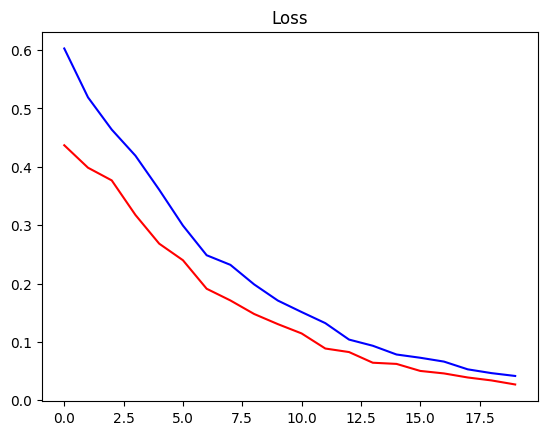

In [30]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

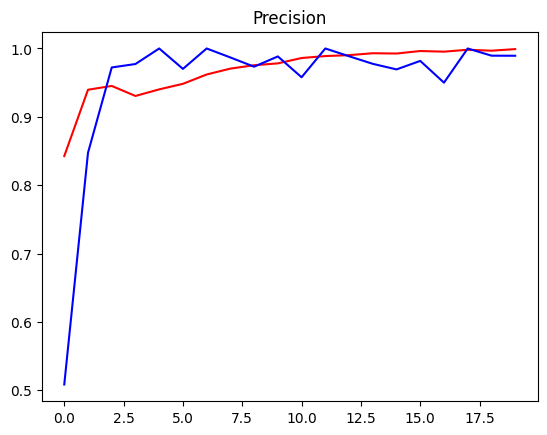

In [31]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

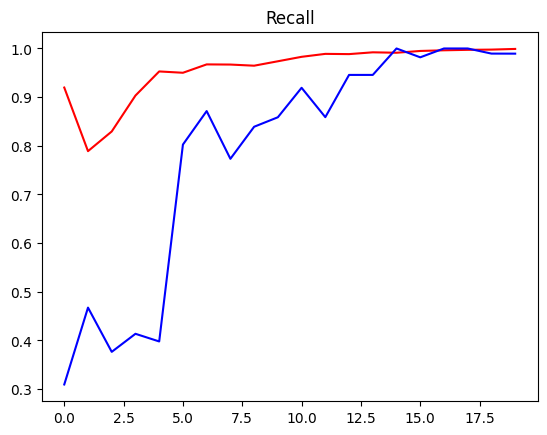

In [32]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

### 8.1 Get One Batch and Make a Prediction

In [33]:
X_test, y_test = test.as_numpy_iterator().next()
yhat = model.predict(X_test)

## Convert Logits to classes
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
ytest = [1 if prediction > 0.5 else 0 for prediction in y_test]
print(ytest, "\n", yhat, sep="")

1/1 [==============================] - 0s 62ms/step
[0, 1, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0]


In [34]:
model.save('leak.keras')